# Dataset and text cleaning

---



In [1]:
%%capture 
!pip install convokit
import convokit
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

In [2]:
%%capture
!pip install contractions
import nltk
nltk.download('all'); #all
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import csv
import re
import string
import random
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
import sklearn.metrics as metrics
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
#Alg
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#For text
!pip install emoji
import emoji
import spacy

In [3]:
nlp = spacy.load('en_core_web_sm')
def clean_tweet(tweet):
    punctuation = string.punctuation + '”'
    tweet = tweet.lower()
    tweet = contractions.fix(tweet)
    tweet = re.sub(r"\n", '', tweet) #new lines
    tweet = re.sub(r"\d+", "", tweet) #digits
    tweet = re.sub(r'http\S+', '', tweet) #links
    tweet = re.sub(r'@\S+', '', tweet)
    tweet = re.sub(r'@\s*\w+', '', tweet)
    tweet = tweet.replace("_", " ")
    tweet = tweet.replace("-", " ")
    tweet = re.sub(r'\\[a-z0-9]{3}', '', tweet)
    tweet = tweet.translate(tweet.maketrans('', '', punctuation))
    #tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)# remove emojis
    tweet = emoji.demojize(tweet, delimiters=("", ""))
    tweet = tweet.replace("_", " ")
    doc = nlp(tweet)
    words = [token.lemma_ for token in doc if not token.is_stop and len(token.text) > 2 or token.text in ["no","yes",'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'against', 'no', 'nor', 'not']]
    tweet = ' '.join(words)
    
    return tweet

In [ ]:
random.seed(15)
replace_with_synonyms("""Goodfellas was authentic and sort of provided the anchor for the genre.
Also, Pesci, DeNiro, and Liotta were perfect trio. 
But, popular opinion is that Casino has way better ending!
@DeNiro that acting was 🔥 🔥 😊 . I want sequel #Casino! 😭
""")

'Goodfellas was authentic and kind of provided the anchor for the genre . besides , Pesci , DeNiro , and Liotta were perfect three . But , popular impression is that casino has way well ending ! @ DeNiro that acting was 🔥 🔥 😊 . I want sequel # casino ! 😭'

In [ ]:
clean_tweet("""Goodfellas was authentic and sort of provided the anchor for the genre . besides , Pesci , DeNiro , and Liotta were perfect trio . 
But , democratic impression is that casino has room well ending ! 
@ DeNiro that acting was 🔥 🔥 😊 . I want sequel # casino ! 😭""")

'goodfellas authentic sort provide anchor genre pesci deniro liotta perfect trio democratic impression casino room end acting fire fire smile face smile eye want sequel casino loudly cry face'

In [4]:
df = pd.read_csv('all_merged.txt', delimiter='\t',header=None)
df.columns =['Id', 'Text', 'Emotion', 'Weight']
df.pop("Weight")
df.head(3)

,Id,Text,Emotion
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger
1,10001,So my Indian Uber driver just called someone t...,anger
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger


In [5]:
# Split the data into train and test sets
X = df["Text"]
y = df["Emotion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=43)

# Define the oversamplers
oversampler_train = RandomOverSampler(sampling_strategy={"anger": 1801, "joy": 1801, "sadness": 1801}, random_state=43)
X_train_resampled, y_train_resampled = oversampler_train.fit_resample(X_train.to_frame(), y_train)
print("Number of samples for each class after oversampling:", y_train_resampled.value_counts())

oversampler_test = RandomOverSampler(sampling_strategy={"anger": 451, "joy": 451, "sadness": 451}, random_state=43)
X_test_resampled, y_test_resampled = oversampler_test.fit_resample(X_test.to_frame(), y_test)
print("Number of samples for each class after oversampling:", y_test_resampled.value_counts())

Number of samples for each class after oversampling: anger      1801
fear       1801
joy        1801
sadness    1801
Name: Emotion, dtype: int64
Number of samples for each class after oversampling: sadness    451
fear       451
anger      451
joy        451
Name: Emotion, dtype: int64


In [6]:
# Print the new instances that are oversampled
print("New instances in the training set:")
added_test=X_test_resampled[X_test.shape[0]:]
added_train=X_train_resampled[X_train.shape[0]:]

New instances in the training set:


In [7]:
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
def replace_with_synonyms(text):
# Expand contractions
    text = contractions.fix(text)  
# Tokenize sentences and words
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]
# Tag parts of speech and replace with synonyms
    new_words = []
    for sentence in words:
        tagged_sentence = pos_tag(sentence)
        new_sentence = []
        for word, tag in tagged_sentence:
            if tag.startswith('N'):
                synset = wordnet.synsets(word, pos=wordnet.NOUN)
            elif tag.startswith('J'):
                synset = wordnet.synsets(word, pos=wordnet.ADJ)
            elif tag.startswith('R'):
                synset = wordnet.synsets(word, pos=wordnet.ADV)
            else:
                new_sentence.append(word)
                continue
            if synset:
                synonyms = [syn.lemmas()[0].name() for syn in synset]
                new_word = random.choice(synonyms)
            else:
                new_word = word
            new_sentence.append(new_word)
        new_words.append(new_sentence)
    new_text = ' '.join([' '.join(sentence) for sentence in new_words])
    return new_text


In [8]:
random.seed(42) 
X_test_resampled.loc[1421	:, 'Text'] = X_test_resampled.loc[1421:, 'Text'].apply(replace_with_synonyms)
X_train_resampled.loc[5681:, 'Text'] = X_train_resampled.loc[5681:, 'Text'].apply(replace_with_synonyms)

In [9]:
X_train_resampled=X_train_resampled['Text'] .map(lambda a:clean_tweet(a))
X_test_resampled=X_test_resampled['Text'].map(lambda a:clean_tweet(a))

In [10]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), use_idf=True,min_df=2,max_df=0.9) #Unigrams, bigrams...
X_train_resampled = tf_idf.fit_transform(X_train_resampled)
X_test_resampled = tf_idf.transform(X_test_resampled)
print("n_samples: %d, n_features: %d" % X_train_resampled.shape)
print("n_samples: %d, n_features: %d" % X_test_resampled.shape)

n_samples: 7204, n_features: 16619
n_samples: 1804, n_features: 16619


### Just checking hashtags

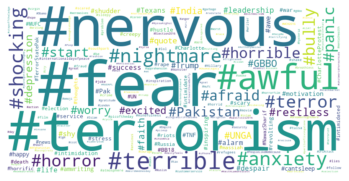

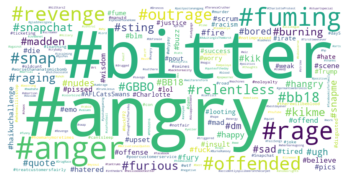

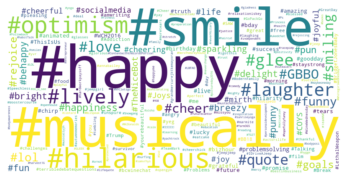

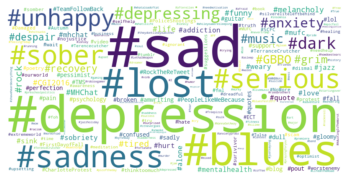

In [ ]:
# regular expression to match hashtags
regex = r"#\w+"
# empty dictionaries for each class
fear_hashtags = {}
anger_hashtags = {}
joy_hashtags = {}
sadness_hashtags = {}
for index, row in df.iterrows():
    tweet = row["Text"]
    emotion = row["Emotion"]
    # Find all hashtags in tweet using regex
    hashtags = re.findall(regex, tweet)
    # Add hashtags to dictionary based on emotion class
    if emotion == "fear":
        for hashtag in hashtags:
            fear_hashtags[hashtag] = fear_hashtags.get(hashtag, 0) + 1
    elif emotion == "anger":
        for hashtag in hashtags:
            anger_hashtags[hashtag] = anger_hashtags.get(hashtag, 0) + 1
    elif emotion == "joy":
        for hashtag in hashtags:
            joy_hashtags[hashtag] = joy_hashtags.get(hashtag, 0) + 1
    elif emotion == "sadness":
        for hashtag in hashtags:
            sadness_hashtags[hashtag] = sadness_hashtags.get(hashtag, 0) + 1

def plot_wordcloud(word_dict):
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_dict)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(fear_hashtags)
plot_wordcloud(anger_hashtags)
plot_wordcloud(joy_hashtags)
plot_wordcloud(sadness_hashtags)


# Models (different algorithms)

---



### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
# Define the SVM model
svm_model = SVC(random_state=5)

# Define the hyperparameter grid to search
hyperparameter_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'sigmoid'],
    'gamma': [0.01, 0.1, 1, 10],
    'shrinking': [True, False]
}

# Define the scorers
scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

# Define the grid search object
grid_search = GridSearchCV(svm_model, hyperparameter_grid, scoring=scoring, refit='F1', cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and the corresponding mean cross-validation F1 score and accuracy
print('Best hyperparameters: ', grid_search.best_params_)
print('Best F1 score: ', grid_search.best_score_)
print('Best accuracy: ', grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])

Best hyperparameters:  {'C': 1, 'gamma': 0.01, 'kernel': 'linear', 'shrinking': True}
Best F1 score:  0.8974851038288595
Best accuracy:  0.8974233749710848


              precision    recall  f1-score   support

       anger       0.86      0.81      0.83       451
        fear       0.80      0.90      0.85       451
         joy       0.94      0.88      0.91       451
     sadness       0.82      0.81      0.82       451

    accuracy                           0.85      1804
   macro avg       0.86      0.85      0.85      1804
weighted avg       0.86      0.85      0.85      1804



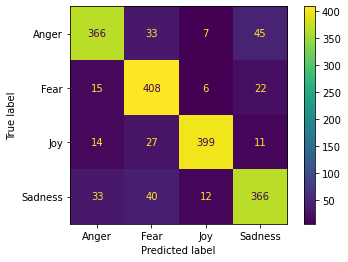

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(C=1, gamma=0.01,kernel="linear",shrinking=True)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, y_pred_svm))
confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anger", "Fear","Joy","Sadness"])

cm_display.plot()
plt.show()

### Passive Aggressive

In [ ]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier

# Define your model
pac = PassiveAggressiveClassifier(random_state=5)

# Define the hyperparameters to tune
params = {
    'C': [0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1.0, 10.0],
    'max_iter': [5000, 8000, 10000],
    'tol': [1e-4, 1e-3, 1e-2, 0.01],
    'loss': ['hinge', 'squared_hinge',"modified_huber","log", "modified_huber", "perceptron"],
    'shuffle': [True, False],
    'early_stopping': [True, False]
}

# Define the scoring metrics to use for grid search
scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=pac, param_grid=params, scoring=scoring, cv=5, refit='F1')
grid.fit(X_train_resampled, y_train_resampled)

# Print the best parameters, F1 score, and accuracy score
print('Best parameters:', grid.best_params_)
print('Best F1 score:', grid.best_score_)
print('Best accuracy:', grid.cv_results_['mean_test_accuracy'][grid.best_index_])

Best parameters: {'C': 0.01, 'early_stopping': False, 'loss': 'hinge', 'max_iter': 5000, 'shuffle': True, 'tol': 0.001}
Best F1 score: 0.9055738699444866
Best accuracy: 0.9056110725576374


              precision    recall  f1-score   support

       anger       0.87      0.83      0.85       451
        fear       0.84      0.89      0.86       451
         joy       0.92      0.91      0.92       451
     sadness       0.82      0.82      0.82       451

    accuracy                           0.86      1804
   macro avg       0.86      0.86      0.86      1804
weighted avg       0.86      0.86      0.86      1804



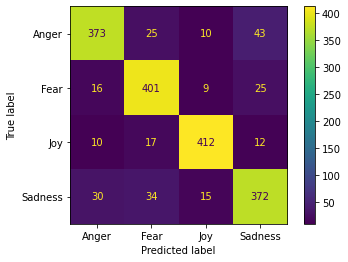

In [31]:
from sklearn.svm import SVC 
from sklearn.linear_model import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(C=0.01, max_iter=5000,tol=0.001,loss="hinge",random_state=5,shuffle=True)
pac.fit(X_train_resampled, y_train_resampled)
y_pred_pac = pac.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, y_pred_pac))
confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_pac)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anger", "Fear","Joy","Sadness"])

cm_display.plot()
plt.show()

### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, 30, 40, 50],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Define the model to use
rfc = RandomForestClassifier(random_state=42)

# Define the scoring metric to use
scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring=scoring, refit='F1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)
print('Best accuracy:', grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])


Best hyperparameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'log2', 'n_estimators': 400}
Best F1 score: 0.8753858901193429
Best accuracy: 0.8749346518621328


              precision    recall  f1-score   support

       anger       0.88      0.83      0.86       451
        fear       0.76      0.93      0.84       451
         joy       0.94      0.88      0.91       451
     sadness       0.81      0.73      0.77       451

    accuracy                           0.84      1804
   macro avg       0.85      0.84      0.84      1804
weighted avg       0.85      0.84      0.84      1804



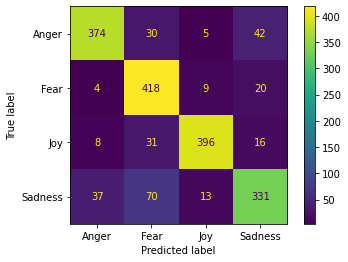

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=400, max_depth=50, random_state=42,bootstrap=True,max_features="log2")

# Train the model using the training sets
rfc.fit(X_train_resampled, y_train_resampled)

# Predict the response for test dataset
y_pred_rfc = rfc.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, y_pred_rfc))

confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_rfc)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anger", "Fear","Joy","Sadness"])

cm_display.plot()
plt.show()


### SGD

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Define your model
sgd = SGDClassifier(random_state=5)

# Define the hyperparameters to tune
params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'max_iter': [5000, 8000, 10000],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'learning_rate': ['constant', 'optimal'],
    'loss':  ["hinge", "log"],
    'eta0': [0.01, 0.1, 1]
}

# Define the scoring metrics to use for grid search
scoring = {'F1': make_scorer(f1_score, average='weighted'), 'Accuracy': make_scorer(accuracy_score)}

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=sgd, param_grid=params, scoring=scoring, cv=5, refit='F1')
grid.fit(X_train_resampled, y_train_resampled)

# Print the best parameters, F1 score, and accuracy
print('Best parameters:', grid.best_params_)
print('Best F1 score:', grid.best_score_)
print('Best Accuracy:', grid.cv_results_['mean_test_Accuracy'][grid.best_index_])

Best parameters: {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'hinge', 'max_iter': 5000, 'penalty': 'elasticnet'}
Best F1 score: 0.9062269051247618
Best Accuracy: 0.9063057097694502


              precision    recall  f1-score   support

       anger       0.88      0.83      0.86       451
        fear       0.84      0.89      0.87       451
         joy       0.93      0.92      0.92       451
     sadness       0.84      0.83      0.83       451

    accuracy                           0.87      1804
   macro avg       0.87      0.87      0.87      1804
weighted avg       0.87      0.87      0.87      1804



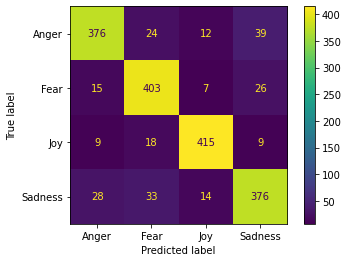

In [209]:
sgd = SGDClassifier(alpha=0.0001, max_iter=5000, random_state=5,penalty="elasticnet",learning_rate="constant",loss="hinge",eta0 = 0.1)
sgd.fit(X_train_resampled, y_train_resampled)
y_pred_sgd = sgd.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, y_pred_sgd))
confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_sgd)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anger", "Fear","Joy","Sadness"])
cm_display.plot()
plt.show()

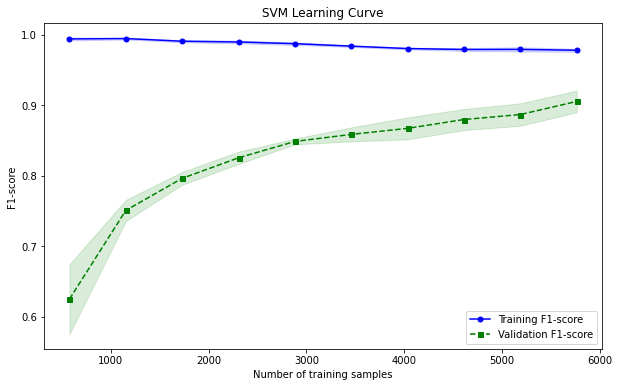

In [ ]:
#Ploting the curve for overfiting
from sklearn.model_selection import learning_curve

# Create a svm Classifier
sgd = SGDClassifier(alpha=0.0001, max_iter=5000, random_state=5,penalty="elasticnet",learning_rate="constant",loss="hinge",eta0 = 0.1)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(sgd, X_train_resampled, y_train_resampled, cv=5, 
                                                        scoring='f1_micro', train_sizes=np.linspace(0.1, 1.0, 10))

# Compute the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1-score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation F1-score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('F1-score')
plt.title('Learning Curve')
plt.legend(loc='lower right')
plt.show()

### Naive Bayes

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Define parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [0.001,0.01,0.1,1,10,100],
    'fit_prior': [True, False]
}

# Create a Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'Accuracy': make_scorer(accuracy_score)
}

# Perform grid search with cross-validation to find best parameters based on F1 and accuracy scores
grid_search = GridSearchCV(estimator=naive_bayes_classifier,
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=5,
                           refit='F1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and scores
print("Best parameters: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)
print("Best Accuracy score: ", grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])


Best parameters:  {'alpha': 1, 'fit_prior': True}
Best F1 score:  0.8664514949862078
Best Accuracy score:  0.8664710077878016


              precision    recall  f1-score   support

       anger       0.83      0.80      0.81       451
        fear       0.78      0.89      0.83       451
         joy       0.89      0.90      0.89       451
     sadness       0.80      0.70      0.75       451

    accuracy                           0.82      1804
   macro avg       0.82      0.82      0.82      1804
weighted avg       0.82      0.82      0.82      1804



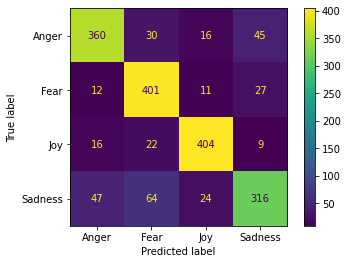

In [ ]:
#naive bayes classifier

naive_bayes_classifier = MultinomialNB(alpha=1, fit_prior=True)
naive_bayes_classifier.fit(X_train_resampled, y_train_resampled)
#predicted y
y_pred_nb = naive_bayes_classifier.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, y_pred_nb))

confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_nb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anger", "Fear","Joy","Sadness"])

cm_display.plot()
plt.show()

### LogisticRegression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# Define the solvers to search over
solvers = ['newton-cg', 'liblinear',"saga","lbfgs","sag"]

# Define the pipeline that scales the data and applies logistic regression with hyperparameter tuning
pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(random_state=0))

# Define the range of hyperparameters to search over, including the solvers
param_grid = {
    'logisticregression__C': [ 0.001, 0.0001, 0.00001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': solvers,
    'logisticregression__max_iter': [8000, 9000, 10000]
}

scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

# Perform a 5-fold cross-validation with hyperparameter tuning based on F1 score
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=scoring, refit='F1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and the classification report for the test set
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)
print('Best accuracy:', grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])


Best hyperparameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 8000, 'logisticregression__solver': 'sag'}
Best F1 score:  0.8196716522132567
Best accuracy: 0.8198349911327011


              precision    recall  f1-score   support

       anger       0.78      0.76      0.77       451
        fear       0.80      0.81      0.81       451
         joy       0.82      0.83      0.83       451
     sadness       0.74      0.74      0.74       451

    accuracy                           0.79      1804
   macro avg       0.79      0.79      0.79      1804
weighted avg       0.79      0.79      0.79      1804



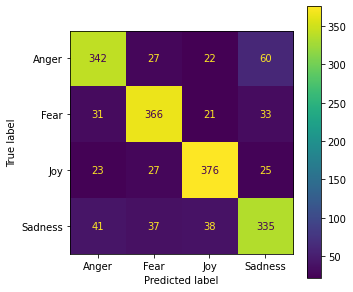

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
logR = LogisticRegression(C=0.01, max_iter=8000, random_state=0, solver='sag')
logR.fit(X_train_resampled, y_train_resampled)
y_pred_logR = logR.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, y_pred_logR))

confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_logR)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anger", "Fear","Joy","Sadness"])
fig, ax = plt.subplots(figsize=(5, 5)) # increase the figure size dpi=300
cm_display.plot(ax=ax)
plt.show()

# Movies - Casino and Goodfellas -  Cornell Movie-Dialogs Corpus

---



Casino

In [24]:
corpus.print_summary_stats()

Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [25]:
uttterances_casino=corpus.get_utterances_dataframe()
uttterances_casino=uttterances_casino[uttterances_casino['meta.movie_id']=='m289']
uttterances_casino.drop(['meta.parsed', 'vectors',"timestamp"], axis=1, inplace=True)

speakers_casino=corpus.get_speakers_dataframe()
speakers_casino=speakers_casino[speakers_casino['meta.movie_name']=='casino']
speakers_casino.drop(['meta.gender', 'vectors',"meta.credit_pos"], axis=1, inplace=True)
conversations_casino=corpus.get_conversations_dataframe()
conversations_casino=conversations_casino[conversations_casino['meta.movie_idx'	]=='m289']
conversations_casino.drop(['meta.release_year', 'vectors',"meta.rating","meta.votes","meta.genre"], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
utterances_with_speakers_casino = pd.merge(speakers_casino, uttterances_casino, how='inner', left_on = 'id', right_on = 'speaker')
utterances_with_speakers_casino.drop(['meta.movie_name', 'meta.movie_idx',"meta.movie_id"], axis=1, inplace=True)
desired_speakers_casino = ["ACE", "NICKY", "GINGER","LESTER","GAGGI", "JENNIFER", "MARINO", "PISCANO"]
utterances_with_speakers_casino = utterances_with_speakers_casino[utterances_with_speakers_casino['meta.character_name'].isin(desired_speakers_casino)]
utterances_with_speakers_casino

,meta.character_name,text,speaker,reply_to,conversation_id
0,ACE,"Now, instead of the cops only lookin' at Nicky...",u4331,L120769,L120769
1,ACE,"It turned out Phil Green, Mr Integrity, had a ...",u4331,None,L120737
2,ACE,...was gonna stop what came up next at the cas...,u4331,None,L120733
3,ACE,It's like everything else in this place. You d...,u4331,L120543,L120540
4,ACE,Look at that. Look at this. There's nothin'......,u4331,L120541,L120540
...,...,...,...,...,...
1478,MARINO,Get up.,u4358,L120206,L120206
1479,MARINO,Smarten up.,u4358,None,L119926
1480,MARINO,Of course.,u4358,L119905,L119904
1481,MARINO,"Whoa, whoa, whoa.",u4358,None,L119858


In [47]:
utterances_with_speakers_casino_text=utterances_with_speakers_casino.text
utterances_with_speakers_casino_text_cleaned=utterances_with_speakers_casino_text.apply(clean_tweet)
utterances_with_speakers_casino_text_cleaned_TF_IDF = tf_idf.transform(utterances_with_speakers_casino_text_cleaned)
prediction_casino = sgd.predict(utterances_with_speakers_casino_text_cleaned_TF_IDF)
prediction_casino = pd.DataFrame(prediction_casino)
prediction_casino = prediction_casino.rename(columns={0: 'predicted_emotion'})
prediction_casino.head(3)


,predicted_emotion
0,fear
1,fear
2,anger


In [48]:
# reset the index of each dataframe
utterances_with_speakers_casino.reset_index(drop=True, inplace=True)
prediction_casino.reset_index(drop=True, inplace=True)
character_emotions_casino = pd.concat([utterances_with_speakers_casino, prediction_casino], axis=1)
character_emotions_casino

,meta.character_name,text,speaker,reply_to,conversation_id,predicted_emotion
0,ACE,"Now, instead of the cops only lookin' at Nicky...",u4331,L120769,L120769,fear
1,ACE,"It turned out Phil Green, Mr Integrity, had a ...",u4331,None,L120737,fear
2,ACE,...was gonna stop what came up next at the cas...,u4331,None,L120733,anger
3,ACE,It's like everything else in this place. You d...,u4331,L120543,L120540,anger
4,ACE,Look at that. Look at this. There's nothin'......,u4331,L120541,L120540,joy
...,...,...,...,...,...,...
1230,MARINO,Get up.,u4358,L120206,L120206,joy
1231,MARINO,Smarten up.,u4358,None,L119926,joy
1232,MARINO,Of course.,u4358,L119905,L119904,anger
1233,MARINO,"Whoa, whoa, whoa.",u4358,None,L119858,fear


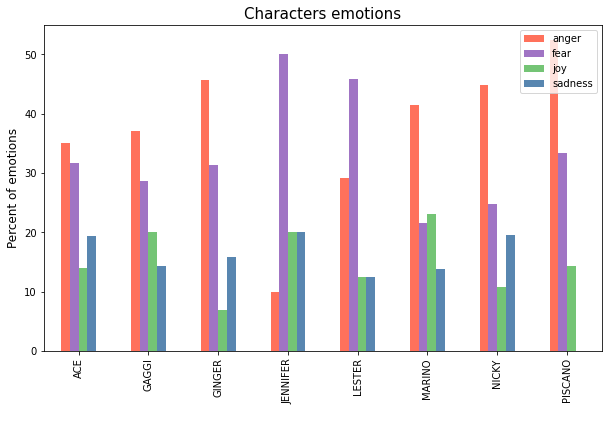

In [97]:
# goup by character_name and predicted_emotion, and count the number of occurrences
emotion_counts_casino = character_emotions_casino.groupby(['meta.character_name', 'predicted_emotion']).size()

# calculate the percentage of each emotion for each character
emotion_percents_casino = emotion_counts_casino.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# unstack the multi-level index to get a separate column for each emotion
emotion_percents_casino = emotion_percents_casino.unstack()

# set custom colors
colors = {'fear': '#A074C4', 'anger': '#FF715B', 'joy': '#74C475', 'sadness': '#5886B0'}

# plot the percentages as a stacked bar chart
ax = emotion_percents_casino.plot(kind='bar', stacked=False, figsize=(10, 6), color=colors)

plt.title('Characters emotions', fontsize=15,fontname="Helvetica")
ax.set_ylabel('Percent of emotions', fontsize=12)
ax.set_xlabel(' ', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper right')
#plt.savefig('casino1.svg', dpi=600)
plt.show()


In [50]:
grouped_casino = character_emotions_casino.groupby(['conversation_id', 'meta.character_name'])['predicted_emotion'].value_counts().unstack().fillna(0).reset_index()
# group by conversation_id and aggregate the other columns
result = grouped_casino.groupby('conversation_id').agg({
    'meta.character_name': lambda x: ', '.join(set(x)),
    'anger': 'sum',
    'fear': 'sum',
    'joy': 'sum',
    'sadness': 'sum'
}).reset_index()
# group by character name and calculate the sum of each emotion
result = result.groupby('meta.character_name').agg({
    'anger': 'sum',
    'fear': 'sum',
    'joy': 'sum',
    'sadness': 'sum'
}).reset_index()

# calculate the total count of all emotions for each character
result['total_emotions'] = result[['anger', 'fear', 'joy', 'sadness']].sum(axis=1)

# divide each emotion column by the total count of all emotions for each character and multiply by 100
result['anger_percent'] = result['anger'] / result['total_emotions'] * 100
result['fear_percent'] = result['fear'] / result['total_emotions'] * 100
result['joy_percent'] = result['joy'] / result['total_emotions'] * 100
result['sadness_percent'] = result['sadness'] / result['total_emotions'] * 100

# drop the original emotion columns and the total count column
result.drop(['anger', 'fear', 'joy', 'sadness', 'total_emotions'], axis=1, inplace=True)


result

result = result.drop(result[result['meta.character_name'].isin(['ACE', 'NICKY',"GINGER","LESTER","PISCANO"])].index)

 #emotions in dialogs
result

predicted_emotion,meta.character_name,anger_percent,fear_percent,joy_percent,sadness_percent
1,"ACE, GAGGI",62.500000,12.500000,0.000000,25.000000
2,"ACE, GINGER",41.666667,31.000000,10.666667,16.666667
3,"ACE, JENNIFER",6.250000,50.000000,12.500000,31.250000
4,"ACE, LESTER",30.000000,43.333333,6.666667,20.000000
5,"ACE, NICKY",42.338710,27.419355,12.500000,17.741935
7,"GINGER, JENNIFER",25.000000,50.000000,25.000000,0.000000
8,"GINGER, LESTER",49.090909,30.909091,12.727273,7.272727
9,"GINGER, NICKY",39.837398,32.520325,7.317073,20.325203
10,"JENNIFER, NICKY",20.000000,46.666667,26.666667,6.666667
12,"MARINO, GAGGI",32.432432,35.135135,18.918919,13.513514


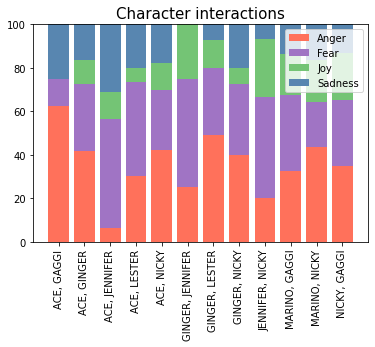

In [98]:
# Define color palette
colors = {'fear': '#A074C4', 'anger': '#FF715B', 'joy': '#74C475', 'sadness': '#5886B0'}

x = range(len(result))
plt.xticks(x, result['meta.character_name'], rotation=90)

# Plot the percentage values for each emotion as stacked bar plot
plt.bar(x, result['anger_percent'], label='Anger', color=colors['anger'])
plt.bar(x, result['fear_percent'], bottom=result['anger_percent'], label='Fear', color=colors['fear'])
plt.bar(x, result['joy_percent'], bottom=result['anger_percent']+result['fear_percent'], label='Joy', color=colors['joy'])
plt.bar(x, result['sadness_percent'], bottom=result['anger_percent']+result['fear_percent']+result['joy_percent'], label='Sadness', color=colors['sadness'])

plt.title('Character interactions', fontsize=15,fontname="Helvetica")
plt.legend(loc='upper right')
#plt.savefig('casino2.svg', dpi=600)

plt.show()



Goodfellas

In [52]:
uttterances_goodfellas=corpus.get_utterances_dataframe()
uttterances_goodfellas=uttterances_goodfellas[uttterances_goodfellas['meta.movie_id']=='m372']
uttterances_goodfellas.drop(['meta.parsed', 'vectors',"timestamp"], axis=1, inplace=True)
speakers_goodfellas=corpus.get_speakers_dataframe()
speakers_goodfellas=speakers_goodfellas[speakers_goodfellas['meta.movie_name']=='goodfellas']
speakers_goodfellas.drop(['meta.gender', 'vectors',"meta.credit_pos"], axis=1, inplace=True)
conversations_goodfellas=corpus.get_conversations_dataframe()
conversations_goodfellas=conversations_goodfellas[conversations_goodfellas['meta.movie_idx'	]=='m372']
conversations_goodfellas.drop(['meta.release_year', 'vectors',"meta.rating","meta.votes","meta.genre"], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [53]:
utterances_with_speakers_goodfellas = pd.merge(speakers_goodfellas, uttterances_goodfellas, how='inner', left_on = 'id', right_on = 'speaker')
utterances_with_speakers_goodfellas.drop(['meta.movie_name', 'meta.movie_idx',"meta.movie_id"], axis=1, inplace=True)
desired_speakers_goodfellas = ["HENRY", "JIMMY","TOMMY","KAREN"]
utterances_with_speakers_goodfellas = utterances_with_speakers_goodfellas[utterances_with_speakers_goodfellas['meta.character_name'].isin(desired_speakers_goodfellas)]
utterances_with_speakers_goodfellas

,meta.character_name,text,speaker,reply_to,conversation_id
12,TOMMY,"No more shines, Billy.",u5602,L248770,L248770
13,TOMMY,Don't go busting my balls. Okay?,u5602,L248767,L248766
14,TOMMY,"Hey, Billy. Watch the suit.",u5602,None,L248766
15,TOMMY,"Billy, how are you?",u5602,L248763,L248763
16,TOMMY,No. It's okay. Just watch this. Watch it.,u5602,L249060,L249058
...,...,...,...,...,...
250,JIMMY,The third store down.,u5592,None,L249401
251,JIMMY,I know. I know. But it'll be okay. Don't worry...,u5592,L249399,L249394
252,JIMMY,I gotta talk to him as soon as I can.,u5592,L249397,L249394
253,JIMMY,Did he say what they're asking him about?,u5592,L249395,L249394


In [54]:
utterances_with_speakers_goodfellas_text=utterances_with_speakers_goodfellas.text
utterances_with_speakers_goodfellas_cleaned=utterances_with_speakers_goodfellas_text.apply(clean_tweet)
utterances_with_speakers_goodfellas_cleaned_TF_IDF = tf_idf.transform(utterances_with_speakers_goodfellas_cleaned)
prediction_goodfellas = sgd.predict(utterances_with_speakers_goodfellas_cleaned_TF_IDF)
prediction_goodfellas = pd.DataFrame(prediction_goodfellas)
prediction_goodfellas = prediction_goodfellas.rename(columns={0: 'predicted_emotion'})
#prediction_goodfellas
# reset the index of each dataframe
utterances_with_speakers_goodfellas.reset_index(drop=True, inplace=True)
prediction_goodfellas.reset_index(drop=True, inplace=True)
character_emotions_goodfellas = pd.concat([utterances_with_speakers_goodfellas, prediction_goodfellas], axis=1)
character_emotions_goodfellas.head(3)

,meta.character_name,text,speaker,reply_to,conversation_id,predicted_emotion
0,TOMMY,"No more shines, Billy.",u5602,L248770,L248770,anger
1,TOMMY,Don't go busting my balls. Okay?,u5602,L248767,L248766,fear
2,TOMMY,"Hey, Billy. Watch the suit.",u5602,None,L248766,joy


In [55]:
grouped_goodfellas = character_emotions_goodfellas.groupby(['conversation_id', 'meta.character_name'])['predicted_emotion'].value_counts().unstack().fillna(0).reset_index()

# group by conversation_id and aggregate the other columns
result_goodfellas = grouped_goodfellas.groupby('conversation_id').agg({
    'meta.character_name': lambda x: ', '.join(set(x)),
    'anger': 'sum',
    'fear': 'sum',
    'joy': 'sum',
    'sadness': 'sum'
}).reset_index()
# group by character name and calculate the sum of each emotion
result_goodfellas = result_goodfellas.groupby('meta.character_name').agg({
    'anger': 'sum',
    'fear': 'sum',
    'joy': 'sum',
    'sadness': 'sum'
}).reset_index()

# calculate the total count of all emotions for each character
result_goodfellas['total_emotions'] = result_goodfellas[['anger', 'fear', 'joy', 'sadness']].sum(axis=1)

# divide each emotion column by the total count of all emotions for each character and multiply by 100
result_goodfellas['anger_percent'] = result_goodfellas['anger'] / result_goodfellas['total_emotions'] * 100
result_goodfellas['fear_percent'] = result_goodfellas['fear'] / result_goodfellas['total_emotions'] * 100
result_goodfellas['joy_percent'] = result_goodfellas['joy'] / result_goodfellas['total_emotions'] * 100
result_goodfellas['sadness_percent'] = result_goodfellas['sadness'] / result_goodfellas['total_emotions'] * 100

# drop the original emotion columns and the total count column
result_goodfellas.drop(['anger', 'fear', 'joy', 'sadness', 'total_emotions'], axis=1, inplace=True)

result_goodfellas = result_goodfellas.drop(result_goodfellas[result_goodfellas['meta.character_name'].isin(['HENRY', 'KAREN',"TOMMY"])].index)

 #emotions in dialogs
result_goodfellas

predicted_emotion,meta.character_name,anger_percent,fear_percent,joy_percent,sadness_percent
1,"HENRY, KAREN",23.076923,46.153846,4.395604,26.373626
2,"JIMMY, HENRY",36.538462,32.692308,11.538462,19.230769
3,"JIMMY, KAREN",44.444444,33.333333,11.111111,11.111111
6,"TOMMY, HENRY",50.000000,25.000000,6.250000,18.750000


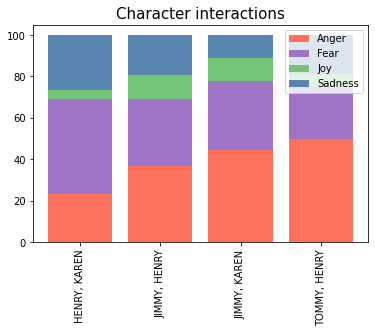

In [99]:
# Define color palette
colors = {'fear': '#A074C4', 'anger': '#FF715B', 'joy': '#74C475', 'sadness': '#5886B0'}

x = range(len(result_goodfellas))
plt.xticks(x, result_goodfellas['meta.character_name'], rotation=90)

plt.bar(x, result_goodfellas['anger_percent'], label='Anger', color=colors['anger'])
plt.bar(x, result_goodfellas['fear_percent'], bottom=result_goodfellas['anger_percent'], label='Fear', color=colors['fear'])
plt.bar(x, result_goodfellas['joy_percent'], bottom=result_goodfellas['anger_percent']+result_goodfellas['fear_percent'], label='Joy', color=colors['joy'])
plt.bar(x, result_goodfellas['sadness_percent'], bottom=result_goodfellas['anger_percent']+result_goodfellas['fear_percent']+result_goodfellas['joy_percent'], label='Sadness', color=colors['sadness'])


plt.title('Character interactions', fontsize=15,fontname="Helvetica")
plt.legend(loc='upper right')

#plt.savefig('goodfellas2.svg', dpi=600)

plt.show()


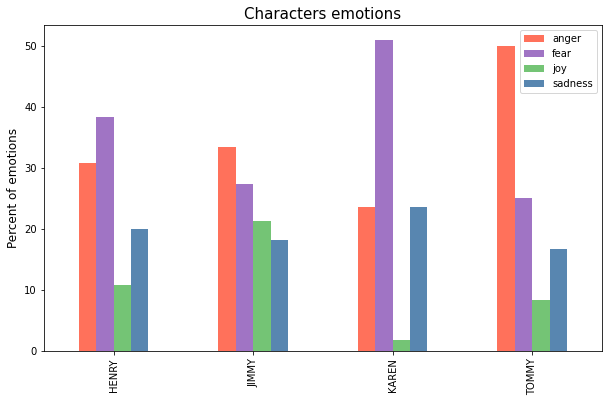

In [100]:
# group by character_name and predicted_emotion, and count the number of occurrences
emotion_counts_goodfellas = character_emotions_goodfellas.groupby(['meta.character_name', 'predicted_emotion']).size()


emotion_percents_goodfellas = emotion_counts_goodfellas.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


emotion_percents_goodfellas = emotion_percents_goodfellas.unstack()

# set custom colors
colors = {'fear': '#A074C4', 'anger': '#FF715B', 'joy': '#74C475', 'sadness': '#5886B0'}


ax = emotion_percents_goodfellas.plot(kind='bar', stacked=False, figsize=(10, 6), color=colors)

plt.title('Characters emotions', fontsize=15,fontname="Helvetica")
ax.set_xlabel(' ', fontsize=12)
ax.set_ylabel('Percent of emotions', fontsize=12)
plt.legend(loc='upper right')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('goodfellas1.svg', dpi=600)
plt.show()

Characters cross the movies

In [58]:
# Group the data by character name and emotion, and count the occurrences
counts = character_emotions_goodfellas.groupby(['meta.character_name', 'predicted_emotion']).size()

totals = counts.groupby(level=0).sum()


percentages_goodfellas = (counts / totals).unstack().fillna(0)

percentages_goodfellas.reset_index(inplace=True)

percentages_goodfellas.columns = ['Name', 'anger', 'fear', 'joy', 'sadness']


print(percentages_goodfellas)

    Name     anger      fear       joy   sadness
0  HENRY  0.308333  0.383333  0.108333  0.200000
1  JIMMY  0.333333  0.272727  0.212121  0.181818
2  KAREN  0.236364  0.509091  0.018182  0.236364
3  TOMMY  0.500000  0.250000  0.083333  0.166667


In [59]:
# Group the data by character name and emotion, and count the occurrences
counts = character_emotions_casino.groupby(['meta.character_name', 'predicted_emotion']).size()

totals = counts.groupby(level=0).sum()

percentages_casino = (counts / totals).unstack()

# Reset the index 
percentages_casino.reset_index(inplace=True)

percentages_casino.columns = ['Name', 'anger', 'fear', 'joy', 'sadness']

print(percentages_casino)

       Name     anger      fear       joy   sadness
0       ACE  0.350538  0.316129  0.139785  0.193548
1     GAGGI  0.371429  0.285714  0.200000  0.142857
2    GINGER  0.457364  0.313953  0.069767  0.158915
3  JENNIFER  0.100000  0.500000  0.200000  0.200000
4    LESTER  0.291667  0.458333  0.125000  0.125000
5    MARINO  0.415385  0.215385  0.230769  0.138462
6     NICKY  0.448916  0.247678  0.108359  0.195046
7   PISCANO  0.523810  0.333333  0.142857       NaN


In [60]:
from sklearn.metrics.pairwise import cosine_similarity

# Set the 'Name' column as the index for each dataframe
percentages_casino.set_index('Name', inplace=True)
percentages_goodfellas.set_index('Name', inplace=True)

# Fill any missing values with zero
percentages_casino.fillna(0, inplace=True)
percentages_goodfellas.fillna(0, inplace=True)

# Create an empty dataframe to store the similarities
similarities_df = pd.DataFrame(columns=['Casino character', 'Goodfellas Character', 'Similarity'])

# Loop through each character in the casino dataframe
for casino_character in percentages_casino.index:
    # Loop through each character in the goodfellas dataframe
    for goodfellas_character in percentages_goodfellas.index:
        # Calculate the cosine similarity between the two characters
        similarity = cosine_similarity([percentages_casino.loc[casino_character]], [percentages_goodfellas.loc[goodfellas_character]])[0][0]
        # Add the similarity to the similarities dataframe
        similarities_df = similarities_df.append({'Casino character': casino_character,
                                                  'Goodfellas Character': goodfellas_character,
                                                  'Similarity': similarity}, ignore_index=True)



In [102]:
similarities_df=similarities_df.sort_values(by='Similarity', ascending=True)
similarities_df.head(20)

,Casino character,Goodfellas Character,Similarity
15,JENNIFER,TOMMY,0.654846
22,MARINO,KAREN,0.744199
30,PISCANO,KAREN,0.762798
26,NICKY,KAREN,0.822653
13,JENNIFER,JIMMY,0.830106
6,GAGGI,KAREN,0.839462
10,GINGER,KAREN,0.866172
19,LESTER,TOMMY,0.866394
28,PISCANO,HENRY,0.882601
12,JENNIFER,HENRY,0.899176


# Movies - Casino and Goodfellas - Subtitle files


---






In [103]:
# read in the subtitle file
with open('/content/Casino.srt', 'r',encoding="cp1252") as f:
    content = f.read()

subtitles = re.findall(r"(\d+)\n(\d\d:\d\d:\d\d,\d+) --> (\d\d:\d\d:\d\d,\d+)\n(.+?)(?=\n\d|\Z)", content, flags=re.DOTALL)

df_casino = pd.DataFrame(subtitles, columns=["key", "start_time", "end_time", "text"])
df_casino["text"] = df_casino["text"].str.replace(r"\n", " ").str.strip()

<ipython-input-103-5cf9981bac3b>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_casino["text"] = df_casino["text"].str.replace(r"\n", " ").str.strip()


In [104]:
df_casino.head(3)

,key,start_time,end_time,text
0,1,"00:00:50,825","00:00:53,195","When you love someone, you've gotta trust them."
1,2,"00:00:53,235","00:00:55,160",There's no other way.
2,3,"00:00:55,195","00:00:58,874",You've got to give them the key to everything ...


In [105]:
df_casino["cleaned_text"]=df_casino["text"].apply(clean_tweet)
df_casino_tf = tf_idf.transform(df_casino["cleaned_text"])
df_casino["predicted_emotion"] = sgd.predict(df_casino_tf)

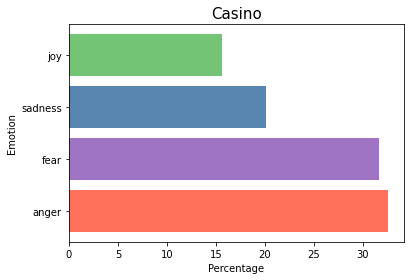

In [109]:
# Calculate the percentage of occurrences of each emotion
emotion_counts_casino1 = (df_casino["predicted_emotion"].value_counts(normalize=True) * 100).round(2)

# Define color palette
colors = {'fear': '#A074C4', 'anger': '#FF715B', 'joy': '#74C475', 'sadness': '#5886B0'}

# Create a horizontal bar plot with custom colors
plt.barh(emotion_counts_casino1.index, emotion_counts_casino1.values, color=[colors[x] for x in emotion_counts_casino1.index])

# Add labels to the plot
plt.xlabel("Percentage")
plt.ylabel("Emotion")
plt.title("Casino",fontname="Helvetica",fontsize=15)
#plt.savefig('casino_all_emotions.svg', dpi=600)
# Show the plot
plt.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------

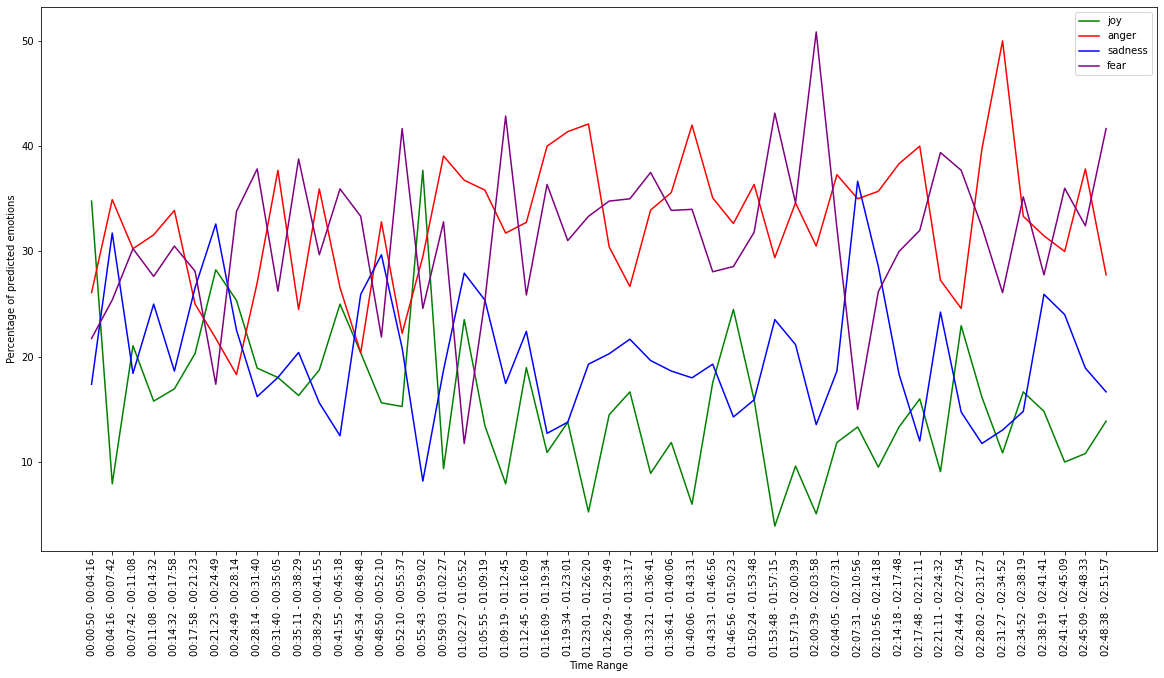

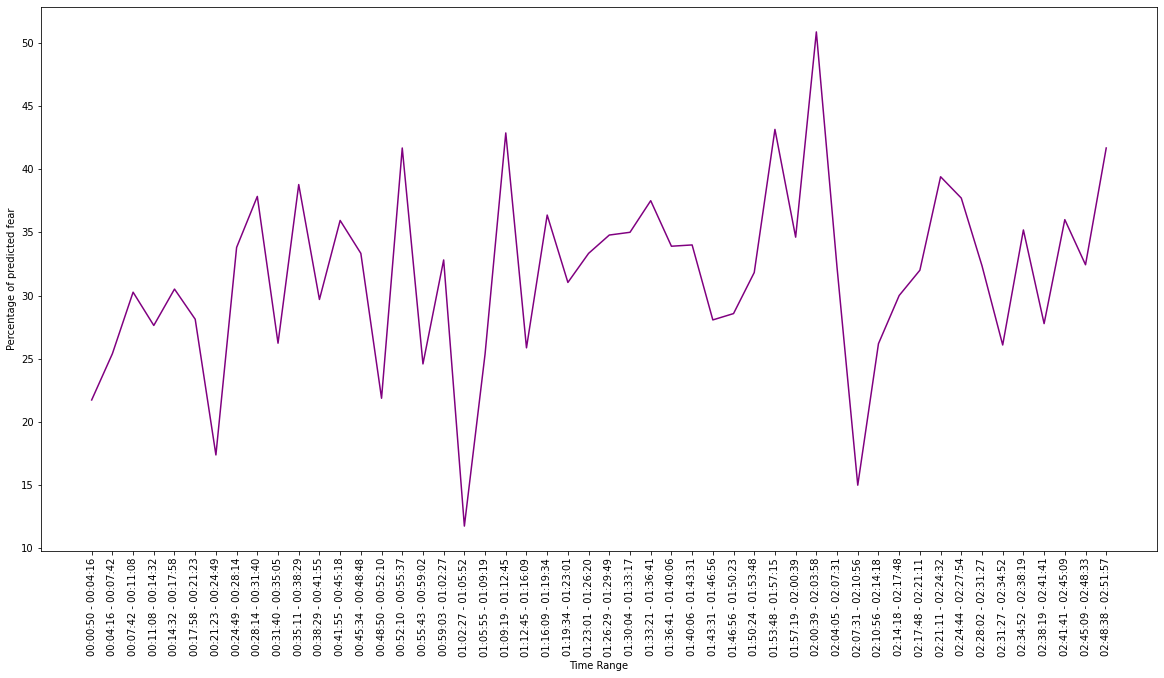

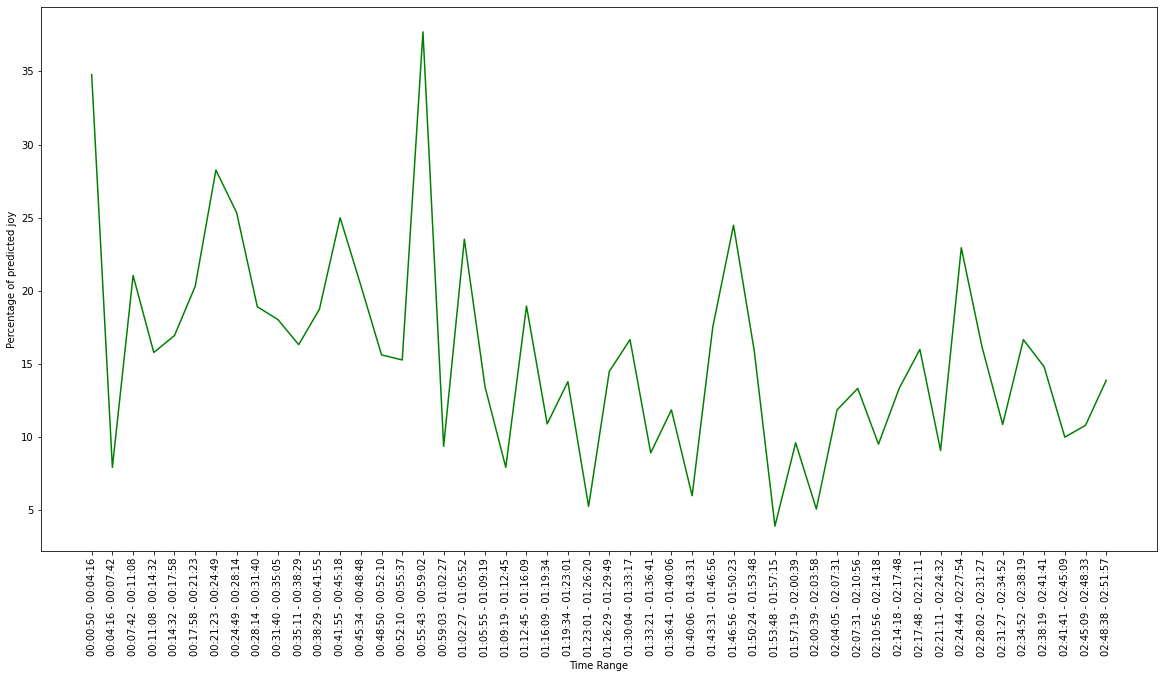

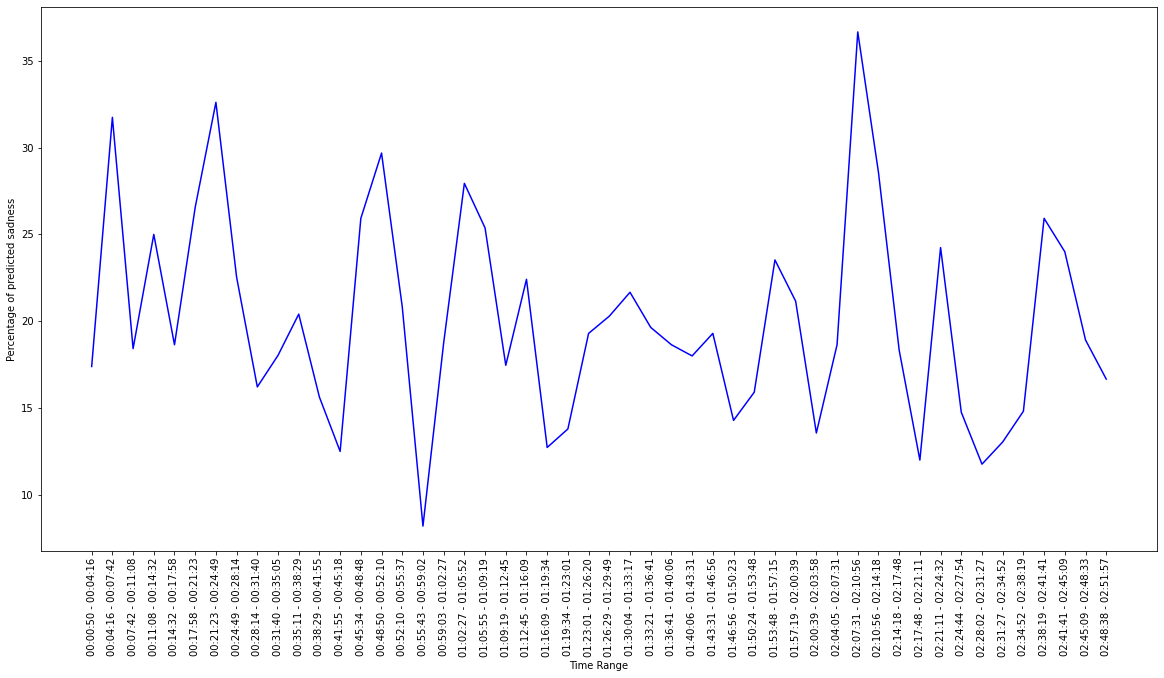

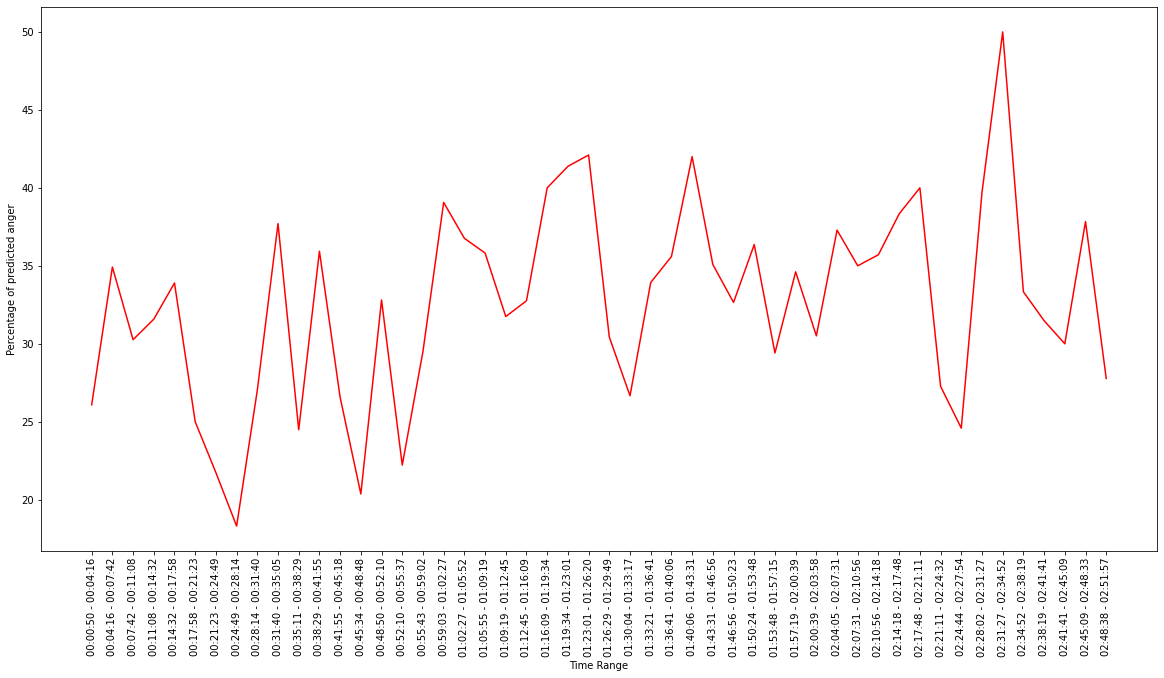

In [116]:
n_chunks = 50 #80
total_time = pd.to_datetime(df_casino['start_time'].iloc[-1]) - pd.to_datetime(df_casino['start_time'].iloc[0])
chunk_size = total_time / n_chunks

chunk_dfs = []
for i in range(n_chunks):
    start_time = pd.to_datetime(df_casino['start_time'].iloc[0]) + chunk_size * i
    end_time = start_time + chunk_size
    chunk_df = df_casino[(pd.to_datetime(df_casino['start_time']) >= start_time) & (pd.to_datetime(df_casino['start_time']) < end_time)]
    chunk_dfs.append(chunk_df)
chunk_stats = []

for i, chunk_df in enumerate(chunk_dfs):
    start_key = chunk_df['key'].iloc[0]
    end_key = chunk_df['key'].iloc[-1]
    start_time = pd.to_datetime(chunk_df['start_time'].iloc[0])
    end_time = pd.to_datetime(chunk_df['end_time'].iloc[-1])
    emotion_counts = chunk_df['predicted_emotion'].value_counts(normalize=True) * 100
    chunk_stats.append({
    'Chunk': i+1,
    'Key Range': f'{start_key}-{end_key}',
    'Time Range': f'{start_time.strftime("%H:%M:%S")} - {end_time.strftime("%H:%M:%S")}',
    'fear': emotion_counts.get('fear', 0),
    'joy': emotion_counts.get('joy', 0),
    'anger': emotion_counts.get('anger', 0),
    'sadness': emotion_counts.get('sadness', 0),
})

chunk_stats_df_casino = pd.DataFrame(chunk_stats)

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
color_dict = {'fear': 'purple', 'joy': 'green', 'sadness': 'blue', 'anger': 'red'}
for emotion in df_casino['predicted_emotion'].unique():
    ax.plot(chunk_stats_df_casino['Time Range'], chunk_stats_df_casino[emotion], label=emotion, color=color_dict[emotion])
ax.legend()
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted emotions')
plt.xticks(rotation=90)
#plt.savefig('casino_all_emotions_big.svg', dpi=600)
plt.show()

# Plotting fear
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(chunk_stats_df_casino['Time Range'], chunk_stats_df_casino['fear'], color='purple')
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted fear')
plt.xticks(rotation=90)
#plt.savefig('casino_all_emotions_fear.svg', dpi=600)
plt.show()

# Plotting joy
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(chunk_stats_df_casino['Time Range'], chunk_stats_df_casino['joy'], color='green')
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted joy')
plt.xticks(rotation=90)
#plt.savefig('casino_all_emotions_joy.svg', dpi=600)
plt.show()

# Plotting sadness
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(chunk_stats_df_casino['Time Range'], chunk_stats_df_casino['sadness'], color='blue')
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted sadness')
plt.xticks(rotation=90)
#plt.savefig('casino_all_emotions_sadness.svg', dpi=600)
plt.show()

# Plotting anger
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(chunk_stats_df_casino['Time Range'], chunk_stats_df_casino['anger'], color='red')
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted anger')
plt.xticks(rotation=90)
#plt.savefig('casino_all_emotions_anger.svg', dpi=600)
plt.show()

Godfellas


In [110]:
# read in the subtitle file
with open('/content/Goodfellas.srt', 'r',encoding="cp1252") as f:
    content = f.read()

subtitles = re.findall(r"(\d+)\n(\d\d:\d\d:\d\d,\d+) --> (\d\d:\d\d:\d\d,\d+)\n(.+?)(?=\n\d|\Z)", content, flags=re.DOTALL)

df_goodfellas = pd.DataFrame(subtitles, columns=["key", "start_time", "end_time", "text"])
df_goodfellas["text"] = df_goodfellas["text"].str.replace(r"\n", " ").str.strip()

<ipython-input-110-236ea949bf6c>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_goodfellas["text"] = df_goodfellas["text"].str.replace(r"\n", " ").str.strip()


In [111]:
df_goodfellas["cleaned_text"]=df_goodfellas["text"].apply(clean_tweet)
df_goodfellas_tf = tf_idf.transform(df_goodfellas["cleaned_text"])
df_goodfellas["predicted_emotion"] = sgd.predict(df_goodfellas_tf)

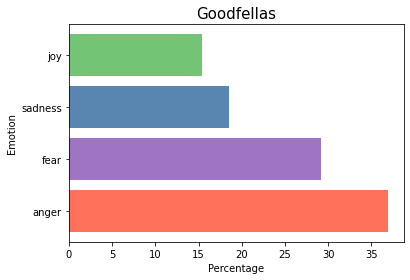

In [113]:
# Calculate the percentage of occurrences of each emotion
emotion_counts_goodfellas1 = (df_goodfellas["predicted_emotion"].value_counts(normalize=True) * 100).round(2)

# Define color palette
colors = {'fear': '#A074C4', 'anger': '#FF715B', 'joy': '#74C475', 'sadness': '#5886B0'}

# Create a horizontal bar plot with custom colors
plt.barh(emotion_counts_goodfellas1.index, emotion_counts_goodfellas1.values, color=[colors[x] for x in emotion_counts_goodfellas1.index])

# Add labels to the plot
plt.xlabel("Percentage")
plt.ylabel("Emotion")
plt.title("Goodfellas",fontname="Helvetica",fontsize=15)
#plt.savefig('goodfellas_all_emotions.svg', dpi=600)
# Show the plot
plt.show()

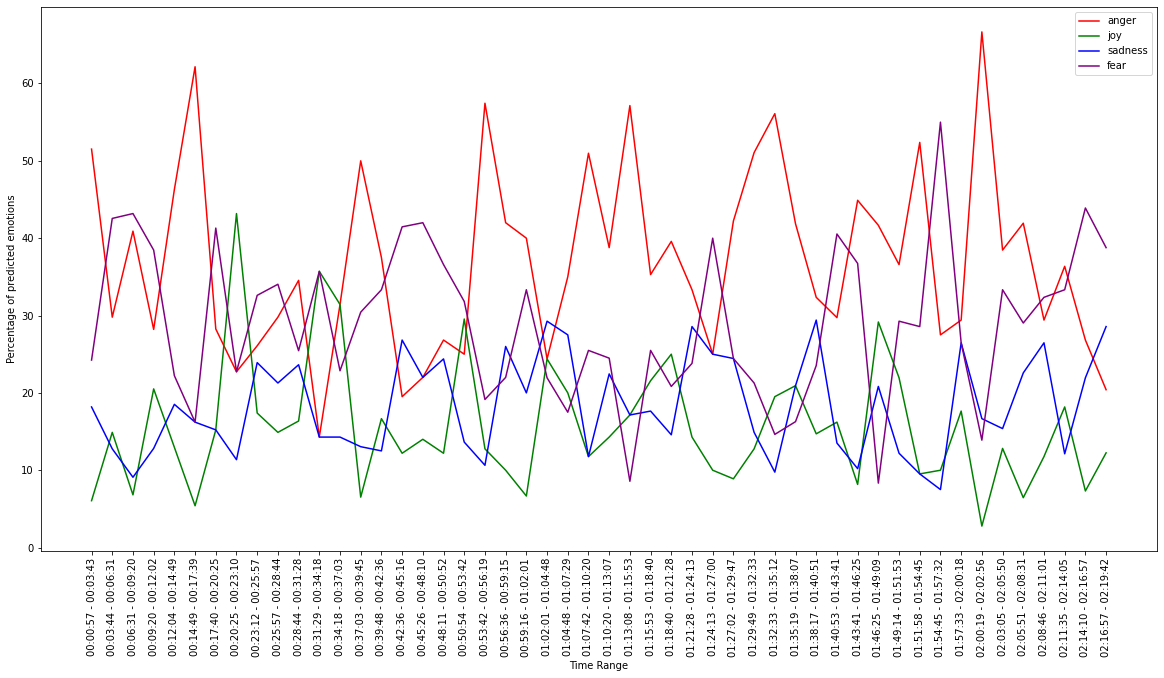

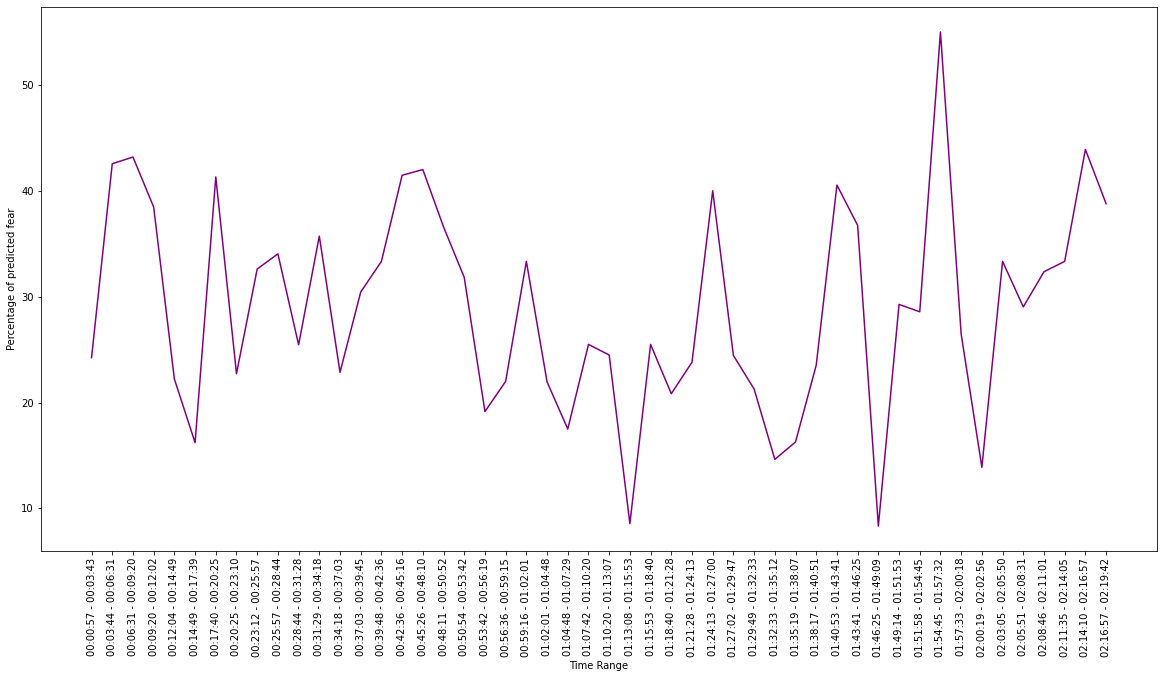

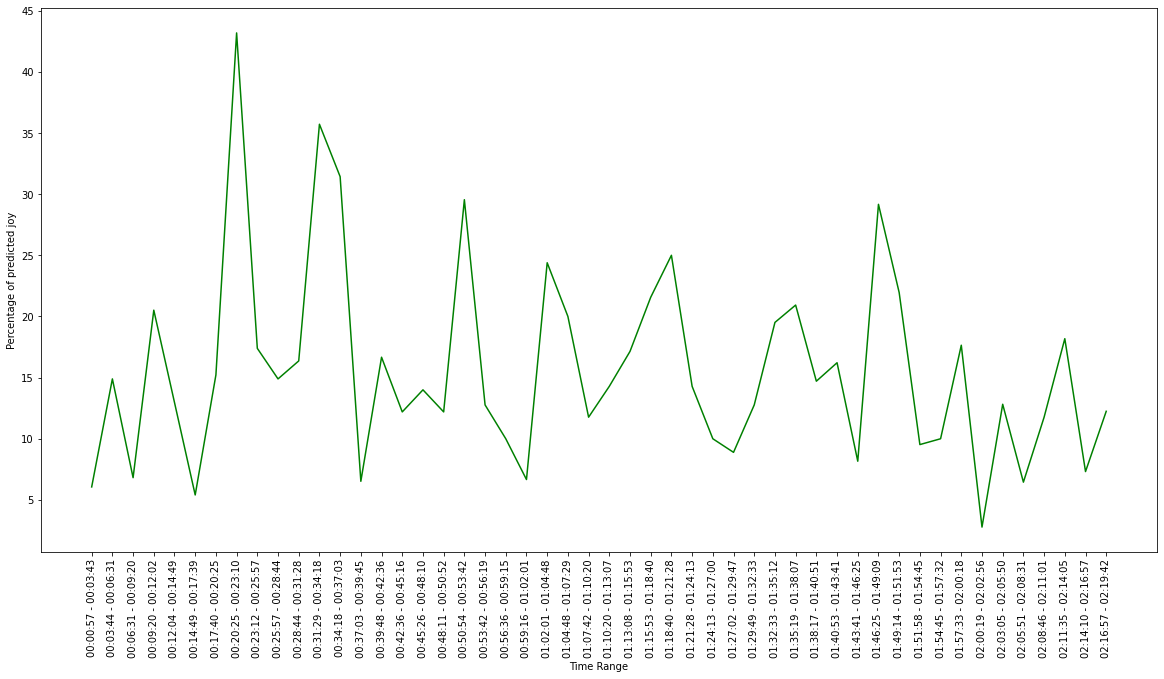

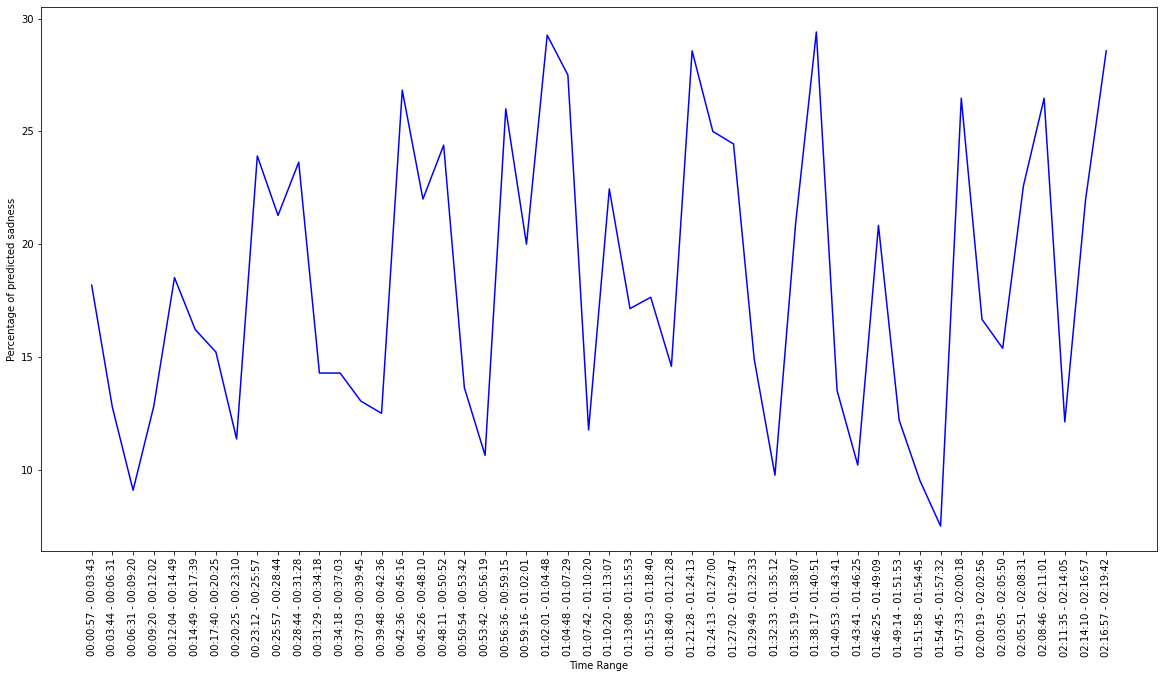

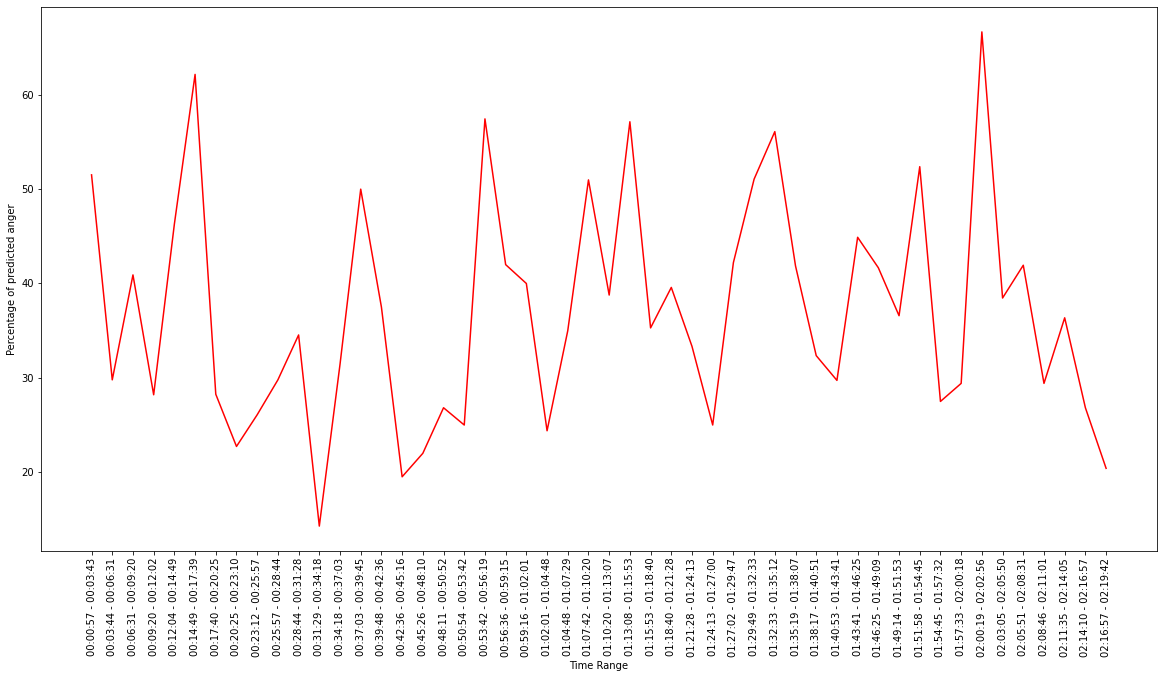

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_chunks = 50 #80 
total_time = pd.to_datetime(df_goodfellas['start_time'].iloc[-1]) - pd.to_datetime(df_goodfellas['start_time'].iloc[0])
chunk_size = total_time / n_chunks

chunk_dfs = []
for i in range(n_chunks):
    start_time = pd.to_datetime(df_goodfellas['start_time'].iloc[0]) + chunk_size * i
    end_time = start_time + chunk_size
    chunk_df = df_goodfellas[(pd.to_datetime(df_goodfellas['start_time']) >= start_time) & (pd.to_datetime(df_goodfellas['start_time']) < end_time)]
    chunk_dfs.append(chunk_df)
chunk_stats = []

for i, chunk_df in enumerate(chunk_dfs):
    start_key = chunk_df['key'].iloc[0]
    end_key = chunk_df['key'].iloc[-1]
    start_time = pd.to_datetime(chunk_df['start_time'].iloc[0])
    end_time = pd.to_datetime(chunk_df['end_time'].iloc[-1])
    emotion_counts = chunk_df['predicted_emotion'].value_counts(normalize=True) * 100
    chunk_stats.append({
    'Chunk': i+1,
    'Key Range': f'{start_key}-{end_key}',
    'Time Range': f'{start_time.strftime("%H:%M:%S")} - {end_time.strftime("%H:%M:%S")}',
    'fear': emotion_counts.get('fear', 0),
    'joy': emotion_counts.get('joy', 0),
    'anger': emotion_counts.get('anger', 0),
    'sadness': emotion_counts.get('sadness', 0),
})

chunk_stats_df_goodfellas = pd.DataFrame(chunk_stats)

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
color_dict = {'fear': 'purple', 'joy': 'green', 'sadness': 'blue', 'anger': 'red'}
for emotion in df_goodfellas['predicted_emotion'].unique():
    ax.plot(chunk_stats_df_goodfellas['Time Range'], chunk_stats_df_goodfellas[emotion], label=emotion, color=color_dict[emotion])
ax.legend()
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted emotions')
plt.xticks(rotation=90)
plt.savefig('goodfellas_all_emotions_big.svg', dpi=600)
plt.show()

# Plotting fear
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(chunk_stats_df_goodfellas['Time Range'], chunk_stats_df_goodfellas['fear'], color='purple')
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted fear')
plt.xticks(rotation=90)
plt.savefig('goodfellas_all_emotions_fear.svg', dpi=600)
plt.show()

# Plotting joy
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(chunk_stats_df_goodfellas['Time Range'], chunk_stats_df_goodfellas['joy'], color='green')
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted joy')
plt.xticks(rotation=90)
plt.savefig('goodfellas_all_emotions_joy.svg', dpi=600)
plt.show()

# Plotting sadness
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(chunk_stats_df_goodfellas['Time Range'], chunk_stats_df_goodfellas['sadness'], color='blue')
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted sadness')
plt.xticks(rotation=90)
plt.savefig('goodfellas_all_emotions_sadness.svg', dpi=600)
plt.show()

# Plotting anger
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(chunk_stats_df_goodfellas['Time Range'], chunk_stats_df_goodfellas['anger'], color='red')
ax.set_xlabel('Time Range')
ax.set_ylabel('Percentage of predicted anger')
plt.xticks(rotation=90)
plt.savefig('goodfellas_all_emotions_anger.svg', dpi=600)
plt.show()

In [119]:
chunk_stats_df_goodfellas
chunk_stats_df_casino 

# Define a function to calculate the cosine similarity between two chunks
def cosine_similarity_chunks(chunk1, chunk2):
    emotions1 = chunk1[['fear', 'anger', 'joy', 'sadness']].values
    emotions2 = chunk2[['fear', 'anger', 'joy', 'sadness']].values
    similarity = cosine_similarity([emotions1], [emotions2])[0][0]
    return similarity

# Compare each chunk in chunk_stats_df_casino with each chunk in chunk_stats_df_goodfellas
similarity_df = pd.DataFrame(columns=['Casino chunks', 'Casino-Time Range', 'Goodfellas chunks', 'Goodfellas-Time Range', 'Similarity'])
for i in range(len(chunk_stats_df_casino)):
    chunk1 = chunk_stats_df_casino.iloc[i]
    for j in range(len(chunk_stats_df_goodfellas)):
        chunk2 = chunk_stats_df_goodfellas.iloc[j]
        similarity = cosine_similarity_chunks(chunk1, chunk2)
        similarity_df = similarity_df.append({'Casino chunks': i+1,
                                              'Casino-Time Range': chunk1['Time Range'],
                                              'Goodfellas chunks': j+1,
                                              'Goodfellas-Time Range': chunk2['Time Range'],
                                              'Similarity': similarity},
                                             ignore_index=True)



In [193]:
similarity_df=similarity_df.sort_values(by='Similarity', ascending=False)
similarity_df.head(10)

,Casino chunks,Casino-Time Range,Goodfellas chunks,Goodfellas-Time Range,Similarity
1259,26,01:26:29 - 01:29:49,10,00:25:57 - 00:28:44,0.999639
2224,45,02:31:27 - 02:34:52,25,01:07:42 - 01:10:20,0.999496
766,16,00:52:10 - 00:55:37,17,00:45:26 - 00:48:10,0.999472
2456,50,02:48:38 - 02:51:57,7,00:17:40 - 00:20:25,0.999290
735,15,00:48:50 - 00:52:10,36,01:38:17 - 01:40:51,0.999278
1221,25,01:23:01 - 01:26:20,22,00:59:16 - 01:02:01,0.999128
2164,44,02:28:02 - 02:31:27,15,00:39:48 - 00:42:36,0.998966
2080,42,02:21:11 - 02:24:32,31,01:24:13 - 01:27:00,0.998832
1471,30,01:40:06 - 01:43:31,22,00:59:16 - 01:02:01,0.998806
729,15,00:48:50 - 00:52:10,30,01:21:28 - 01:24:13,0.998694


In [198]:
casino10=similarity_df.head(10)["Casino chunks"]
goodfellas10=similarity_df.head(10)["Goodfellas chunks"]
similarity=similarity_df.head(10)["Similarity"]


In [200]:
# Convert casino10 and goodfellas10 to lists
casino10_list = casino10.to_list()
goodfellas10_list = goodfellas10.to_list()

# Filter chunk_stats_df_goodfellas to only include the chunks in goodfellas10, in the same order as in goodfellas10_list
goodfellas_subset = chunk_stats_df_goodfellas.loc[chunk_stats_df_goodfellas['Chunk'].isin(goodfellas10_list)]
goodfellas_subset = goodfellas_subset.set_index('Chunk').loc[goodfellas10_list].reset_index()

# Filter chunk_stats_df_casino to only include the chunks in casino10, in the same order as in casino10_list
casino_subset = chunk_stats_df_casino.loc[chunk_stats_df_casino['Chunk'].isin(casino10_list)]
casino_subset = casino_subset.set_index('Chunk').loc[casino10_list].reset_index()

In [201]:
result_df = pd.concat([casino_subset, goodfellas_subset], axis=1)
result_df = result_df.reset_index(drop=True)
result_df.drop(['Key Range', 'Key Range'], axis=1, inplace=True)

In [208]:
result_df

,Chunk,Time Range,fear,joy,anger,sadness,Chunk,Time Range,fear,joy,anger,sadness
0,26,01:26:29 - 01:29:49,34.782609,14.492754,30.434783,20.289855,10,00:25:57 - 00:28:44,34.042553,14.893617,29.787234,21.276596
1,45,02:31:27 - 02:34:52,26.086957,10.869565,50.000000,13.043478,25,01:07:42 - 01:10:20,25.490196,11.764706,50.980392,11.764706
2,16,00:52:10 - 00:55:37,41.666667,15.277778,22.222222,20.833333,17,00:45:26 - 00:48:10,42.000000,14.000000,22.000000,22.000000
3,50,02:48:38 - 02:51:57,41.666667,13.888889,27.777778,16.666667,7,00:17:40 - 00:20:25,41.304348,15.217391,28.260870,15.217391
4,15,00:48:50 - 00:52:10,21.875000,15.625000,32.812500,29.687500,36,01:38:17 - 01:40:51,23.529412,14.705882,32.352941,29.411765
5,25,01:23:01 - 01:26:20,33.333333,5.263158,42.105263,19.298246,22,00:59:16 - 01:02:01,33.333333,6.666667,40.000000,20.000000
6,44,02:28:02 - 02:31:27,32.352941,16.176471,39.705882,11.764706,15,00:39:48 - 00:42:36,33.333333,16.666667,37.500000,12.500000
7,42,02:21:11 - 02:24:32,39.393939,9.090909,27.272727,24.242424,31,01:24:13 - 01:27:00,40.000000,10.000000,25.000000,25.000000
8,30,01:40:06 - 01:43:31,34.000000,6.000000,42.000000,18.000000,22,00:59:16 - 01:02:01,33.333333,6.666667,40.000000,20.000000
9,15,00:48:50 - 00:52:10,21.875000,15.625000,32.812500,29.687500,30,01:21:28 - 01:24:13,23.809524,14.285714,33.333333,28.571429
